# Modelagem magnética 2D

### Pacotes usados para realizar os cálculos e mostrar os resultados

In [1]:
from __future__ import division, absolute_import
from fatiando import mesher, gridder, utils
from fatiando.gravmag import polyprism
from fatiando.vis import mpl

/home/vanderlei/Documents/fatiando/fatiando/vis/mpl.py:70: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.testing import assert_almost_equal as aae

### Funções auxiliares

In [3]:
def rotation_matrix(angle):
    '''
    Orthogonal matrix performing a rotation around
    the z-axis of a Cartesian coordinate system.

    Parameters:
    * angle : float
        Rotation angle (in degrees).

    Returns:
    * R : 2D numpy array
        Rotation matrix.
    '''

    assert isinstance(1.*angle, float), 'angle must be a float'

    ang = np.deg2rad(angle)

    cos_angle = np.cos(ang)
    sin_angle = np.sin(ang)

    R = np.array([[cos_angle, -sin_angle, 0],
                  [sin_angle, cos_angle, 0],
                  [0, 0, 1]])

    return R

In [4]:
def rotate(origin, theta, x, y):
    '''
    Rotate the horizontal coordinates/field components by 'theta' degrees 
    around the 'origin'.
    
    parameters:
    origin: tuple - contains the x and y coordinates of the origin
    theta: float - positive clockwise angle (in degrees) defining the rotation
    x, y: numpy arrays 1D - horizontal coordinates of field components to be rotated
    
    returns:
    x_rotated, y_rotated: numpy arrays 1D - rotated coordinates or field components
    '''
    x = np.asarray(x)
    y = np.asarray(y)
    assert x.shape == y.shape, 'x and y must have the same shape'
    assert isinstance(origin, tuple), 'origin must be a tuple'
    assert len(origin) == 2, 'origin must have 2 elements'
    assert np.isscalar(theta), 'theta must be a scalar'

    theta_rad = np.deg2rad(theta)
    cos = np.cos(theta_rad)
    sin = np.sin(theta_rad)

    x_rotated = cos*(x - origin[0]) - sin*(y - origin[1])
    y_rotated = sin*(x - origin[0]) + cos*(y - origin[1])
    return x_rotated, y_rotated

In [5]:
def vertices_fonte(x0, y0, L, alpha):
    assert np.isscalar(x0), 'x0 must be a scalar'
    assert np.isscalar(y0), 'y0 must be a scalar'
    assert np.isscalar(L), 'L must be a scalar'
    assert np.isscalar(alpha), 'alpha must be a scalar'

    x1 = x0 - 0.5*L
    x2 = x0 + 0.5*L
    y1 = y0 - 1e8
    y2 = y0 + 1e8

    polygon = [[x1, y1],
               [x2, y1],
               [x2, y2],
               [x1, y2]]
    
    theta = alpha - 90.
    origin = (x0, y0)
    
    rot_polygon = rotated_polygon(origin, theta, polygon)

    return rot_polygon

In [6]:
def rotated_polygon(origin, theta, polygon):
    '''
    Compute the corners of a rotated rectangle.
    '''
    rot_polygon = []
    for point in polygon:
        xr, yr = rotate(origin, theta, point[0], point[1])
        rot_polygon.append([xr, yr])
    return rot_polygon

### Parâmetros que definem os sistemas de coordenadas

Considere que os dados estão referidos a um sistema de coordenadas Cartesianas topocêntricas com origem no centro da fonte 2D e eixos $x$, $y$ e $z$ apontados, respectivamente, para Norte, Leste e para baixo. Por conveniência, denominei este sistema como **Sistema dos dados**. Os eixos deste sistema de coordenadas são definidos pelos vetores unitários abaixo:

$
\hat{\mathbf{x}}_{d} = \begin{bmatrix}
1 \\ 0 \\ 0
\end{bmatrix} \quad , \quad
\hat{\mathbf{y}}_{d} = \begin{bmatrix}
0 \\ 1 \\ 0
\end{bmatrix} \quad , \quad
\hat{\mathbf{z}}_{d} = \begin{bmatrix}
0 \\ 0 \\ 1
\end{bmatrix} \quad .
$

A modelagem é feita em um sistema de coordenadas rotacionado, em que o eixo $y$ é alinhado com a direção da fonte 2D. Por conveniência, denominei este sistema como **Sistema da fonte**. Este sistema tem os eixos definidos pelos seguintes vetores unitários:

$
\hat{\mathbf{x}}_{f} = \begin{bmatrix}
\cos \theta \\ \sin \theta \\ 0
\end{bmatrix} \quad , \quad
\hat{\mathbf{y}}_{f} = \begin{bmatrix}
-\sin \theta \\ \cos \theta \\ 0
\end{bmatrix} \quad , \quad
\hat{\mathbf{z}}_{f} = \begin{bmatrix}
0 \\ 0 \\ 1
\end{bmatrix} \quad ,
$

em que $\theta = \alpha - 90^{\circ}$ é o ângulo de rotação do sistema dos dados para o sistema da fonte e $\alpha$ é o azimute da fonte. Estes ângulos definem rotações em torno do eixo $z$ e são positivos no sentido horário (considerando o eixo $z$ entrando no plano da tela do computador).

In [7]:
# Azimute da fonte
alpha = 125.

# Ângulo de rotação entre o sistema dos dados e o sistema da fonte
theta = alpha - 90

A relação entre um vetor $\mathbf{v}_{d}$, definido no sistema dos dados, e um vetor $\mathbf{v}_{f}$, definido no sistema da fonte, é dada por:

$$
\mathbf{v}_{f} = \mathbf{R}(\theta)^{\top} \, \mathbf{v}_{d} \quad ,
$$

em que 

$$
\mathbf{R}(\theta) = \begin{bmatrix}
\cos \theta & -\sin \theta & 0 \\
\sin \theta &  \cos \theta & 0 \\
0           &            0 & 1
\end{bmatrix} = \begin{bmatrix}
\hat{\mathbf{x}}_{f} & \hat{\mathbf{y}}_{f} & \hat{\mathbf{z}}_{f}
\end{bmatrix} \quad .
$$

In [8]:
# Matriz de rotação
R = rotation_matrix(theta)

# A transformação entre um vetor vd no sistema dos dados e 
# um vetor vf no sistema da fonte é dada por vf = R vd

### Modelagem no sistema de coordenadas dos dados

In [9]:
# Região que contem a fonte 2D
bounds = [-10000, 10000, -10000, 10000, 0, 5000]

In [10]:
# Coordenadas da grade regular de pontos no sistema dos dados
shape = (300, 300)
area = bounds[:4]
xd, yd, z0 = gridder.regular(area, shape, z=-300)

A direção do campo principal no sistema dos dados é definida pelo vetor unitário:

$$
\hat{\mathbf{F}}_{d} = \begin{bmatrix}
\cos I^{d}_{0} \, \cos D^{d}_{0} \\
\cos I^{d}_{0} \, \sin D^{d}_{0} \\
\sin I^{d}_{0}
\end{bmatrix} \quad ,
$$

em que $I^{d}_{0}$ e $D^{d}_{0}$ são a inclinação e a declinação do campo principal, respectivamente. 

In [11]:
# Inclinação e declinação (em graus) do campo principal
I0_d, D0_d = -23.5, -19.5

# Vetor unitário na direção do campo principal
F_d = utils.ang2vec(1., I0_d, D0_d)

A direção da magnetização total no sistema dos dados é definida pelo vetor unitário:

$$
\hat{\mathbf{m}}_{d} = \begin{bmatrix}
\cos I^{d} \, \cos D^{d} \\
\cos I^{d} \, \sin D^{d} \\
\sin I^{d}
\end{bmatrix} \quad ,
$$

em que $I^{d}$ e $D^{d}$ são a inclinação e a declinação da magnetização total, respectivamente. 

In [12]:
# Inclinação e declinação (em graus) da magnetização total
I_d, D_d = -40., -10.

# Intensidade da magnetização total (em A/m)
int_mag = 3.

# Magnetização total (vetor unitário definido acima, multiplicado pela intensidade de magnetização)
m_d = utils.ang2vec(int_mag, I_d, D_d)

In [13]:
# Geometria da fonte 2D 

# Topo e base (em metros)
z1, z2 = 100., 2000.

# Coordenadas horizontais do centro da fonte (em metros)
x0d, y0d = 0., 0.

# Largura da fonte (em metros)
L = 5000.

# Vértices da fonte no sentido horário
vertices_d = vertices_fonte(x0d, y0d, L, alpha)

# Modelo de prisma 2D rotacionado
model_d = [mesher.PolygonalPrism(vertices_d, z1, z2, {'magnetization': m_d})]

# Projeção do prisma no plano horizontal
projection_d = mesher.Polygon(vertices_d)

In [14]:
# Anomalia de campo total (ACT)
act_d = polyprism.tf(xd, yd, z0, model_d, I0_d, D0_d)

# Componentes do campo de indução magnética
bx_d = polyprism.bx(xd, yd, z0, model_d)
by_d = polyprism.by(xd, yd, z0, model_d)
bz_d = polyprism.bz(xd, yd, z0, model_d)

In [15]:
ranges_d = np.max(np.abs([act_d, bx_d, by_d, bz_d]))

/home/vanderlei/anaconda3/envs/fatiando2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'picker'
  s)


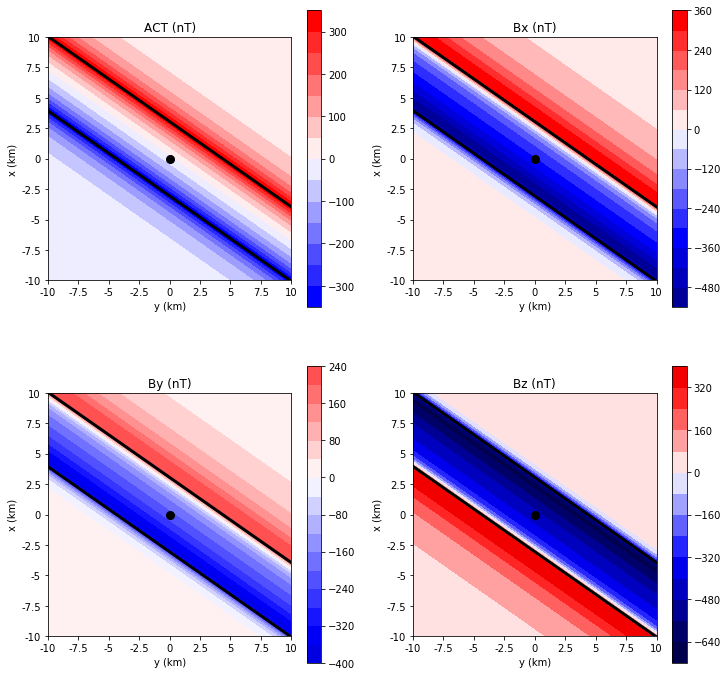

In [16]:
plt.figure(figsize=(12,12))

# Anomalia de campo total (ACT)
plt.subplot(221)
plt.title("ACT (nT)")
plt.axis('scaled')
mpl.contourf(yd, xd, act_d, shape, 15, vmin=-ranges_d, vmax=ranges_d, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_d, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

# Componente Bx
plt.subplot(222)
plt.title("Bx (nT)")
plt.axis('scaled')
mpl.contourf(yd, xd, bx_d, shape, 15, vmin=-ranges_d, vmax=ranges_d, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_d, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

# Componente By
plt.subplot(223)
plt.title("By (nT)")
plt.axis('scaled')
mpl.contourf(yd, xd, by_d, shape, 15, vmin=-ranges_d, vmax=ranges_d, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_d, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

# Componente Bz
plt.subplot(224)
plt.title("Bz (nT)")
plt.axis('scaled')
mpl.contourf(yd, xd, bz_d, shape, 15, vmin=-ranges_d, vmax=ranges_d, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_d, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()


plt.show()

### Modelagem no sistema de coordenadas da fonte

As coordenadas de um ponto no sistema da fonte são definidas em função das coordenadas do mesmo ponto no sistema dos dados da seguinte forma:

$$
\begin{bmatrix} x^{f} \\ y^{f} \\ z^{f} \end{bmatrix} = 
\mathbf{R}(\theta)^{\top} \, 
\begin{bmatrix} x^{d} \\ y^{d} \\ z^{d} \end{bmatrix} \quad .
$$

In [17]:
# Grade regular de pontos no sistema da fonte
# O sinal de menos no ângulo theta indica que a rotação é no sentido anti-horário
# e é compatível com o transposto na matrix R(theta) acima
xf, yf = rotate((0.,0.), -theta, xd, yd)

O vetor unitário que define a direção do campo principal no sistema da fonte é dado por:

$$
\hat{\mathbf{F}}_{f} = \mathbf{R}(\theta)^{\top} \, \hat{\mathbf{F}}_{d} \quad .
$$

In [18]:
# Vetor unitário na direção do campo principal
F_f = np.dot(R.T, F_d)

# # Inclinação e declinação do campo principal
_, I0_f, D0_f = utils.vec2ang(F_f)

O vetor unitário que define a direção da magnetização total da fonte no sistema da fonte é dada por:

$$
\hat{\mathbf{m}}_{f} = \mathbf{R}(\theta)^{\top} \, \hat{\mathbf{m}}_{d} \quad .
$$

In [19]:
# Magnetização total
m_f = np.dot(R.T, m_d)

In [20]:
# Inclinação e declinação da magnetização total
_, I_f, D_f = utils.vec2ang(m_f)

In [21]:
# Geometria da fonte 2D

# Vértices da fonte no sentido horário
vertices_f = rotated_polygon((0.,0.), -theta, vertices_d)

# Modelo de prisma 2D com eixo y infinito
model_f = [mesher.PolygonalPrism(vertices_f, z1, z2, {'magnetization': m_f})]

# Projeção do prisma no plano horizontal
projection_f = mesher.Polygon(vertices_f)

In [22]:
# Anomalia de campo total (ACT)
act_f = polyprism.tf(xf, yf, z0, model_f, I0_f, D0_f)

# Componentes do campo de indução magnética
bx_f = polyprism.bx(xf, yf, z0, model_f)
by_f = polyprism.by(xf, yf, z0, model_f)
bz_f = polyprism.bz(xf, yf, z0, model_f)

In [23]:
ranges_f = np.max(np.abs([act_f, bx_f, by_f, bz_f]))

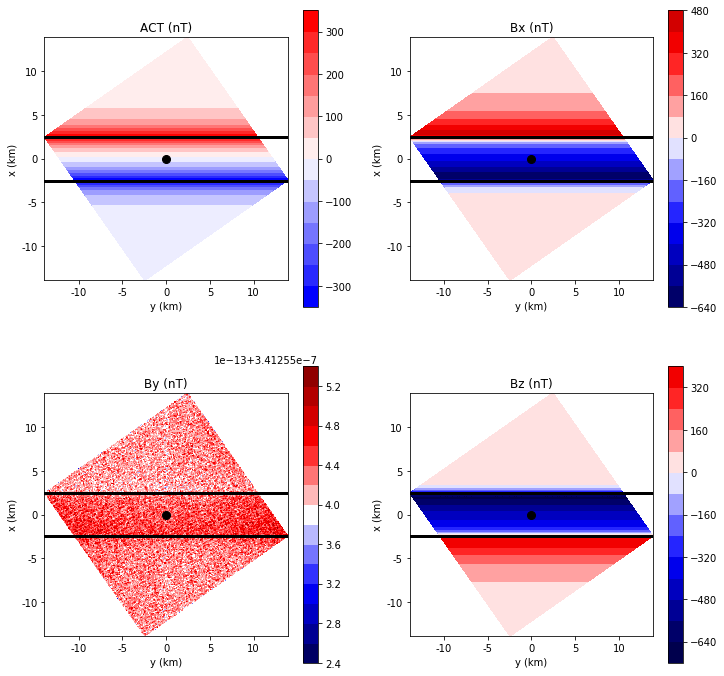

In [24]:
plt.figure(figsize=(12,12))

# Anomalia de campo total (ACT)
plt.subplot(221)
plt.title("ACT (nT)")
plt.axis('scaled')
mpl.contourf(yf, xf, act_f, shape, 15, vmin=-ranges_f, vmax=ranges_f, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_f, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

# Componente Bx
plt.subplot(222)
plt.title("Bx (nT)")
plt.axis('scaled')
mpl.contourf(yf, xf, bx_f, shape, 15, vmin=-ranges_f, vmax=ranges_f, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_f, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

# Componente By
plt.subplot(223)
plt.title("By (nT)")
plt.axis('scaled')
mpl.contourf(yf, xf, by_f, shape, 15, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_f, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

# Componente Bz
plt.subplot(224)
plt.title("Bz (nT)")
plt.axis('scaled')
mpl.contourf(yf, xf, bz_f, shape, 15, vmin=-ranges_f, vmax=ranges_f, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_f, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()


plt.show()

### Relação entre a indução magnética produzida nos dois sistemas de coordenadas

O vetor indução magnética $\mathbf{B}_{f}$ no sistema da fonte pode ser obtido a partir da indução $\mathbf{B}_{d}$ definida no sistema dos dados da seguinte forma:

$$
\mathbf{B}_{f} = \mathbf{R}(\theta)^{\top} \, \mathbf{B}_{d} \quad .
$$

In [25]:
# Indução obtida rotacionando o aquela definida no sistema dos dados
bx_rotated, by_rotated = rotate((0.,0.), -theta, bx_d, by_d)

In [26]:
# Comparação entre a componentes obtidas por rotação e 
# aquelas definidas diretamente no sistema da fonte
aae(bx_rotated, bx_f, decimal=2)
aae(by_rotated, by_f, decimal=2)

In [27]:
# A componente z deve ser igual nos dois sistemas de coordenadas
aae(bz_d, bz_f, decimal=2)

### Separação entre as componentes da magnetização paralela e perpendicular à fonte 2D

In [28]:
# Componente da magnetização paralela à fonte 2D
m_parallel = np.array([0., m_f[1], 0.])

# Componente da magnetização perpendicular à fonte 2D
m_perpendicular = np.array([m_f[0], 0., m_f[2]])

In [29]:
# Inclinação e declinação da componente paralela
_, I_parallel, D_parallel = utils.vec2ang(m_parallel)

# Inclinação e declinação da componente perpendicular
_, I_perpendicular, D_perpendicular = utils.vec2ang(m_perpendicular)

In [30]:
# Modelo com magnetização paralela à fonte
model_parallel = [mesher.PolygonalPrism(vertices_f, z1, z2, {'magnetization': m_parallel})]

In [31]:
# Modelo com magnetização penpendicular à fonte
model_perpendicular = [mesher.PolygonalPrism(vertices_f, z1, z2, {'magnetization': m_perpendicular})]

In [32]:
# Campo produzido pelo modelo com magnetização paralela à fonte

# Anomalia de campo total (ACT)
act_parallel = polyprism.tf(xf, yf, z0, model_parallel, I0_f, D0_f)

# Componentes do campo de indução magnética
bx_parallel = polyprism.bx(xf, yf, z0, model_parallel)
by_parallel = polyprism.by(xf, yf, z0, model_parallel)
bz_parallel = polyprism.bz(xf, yf, z0, model_parallel)

In [33]:
# Campo produzido pelo modelo com magnetização penpendicular à fonte

# Anomalia de campo total (ACT)
act_perpendicular = polyprism.tf(xf, yf, z0, model_perpendicular, I0_f, D0_f)

# Componentes do campo de indução magnética
bx_perpendicular = polyprism.bx(xf, yf, z0, model_perpendicular)
by_perpendicular = polyprism.by(xf, yf, z0, model_perpendicular)
bz_perpendicular = polyprism.bz(xf, yf, z0, model_perpendicular)

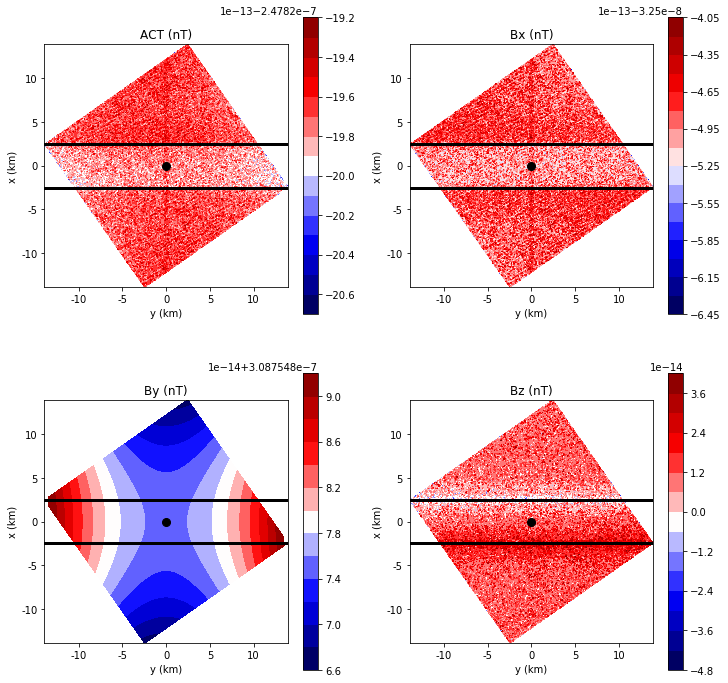

In [34]:
plt.figure(figsize=(12,12))

# Anomalia de campo total (ACT)
plt.subplot(221)
plt.title("ACT (nT)")
plt.axis('scaled')
mpl.contourf(yf, xf, act_parallel, shape, 15, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_f, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

# Componente Bx
plt.subplot(222)
plt.title("Bx (nT)")
plt.axis('scaled')
mpl.contourf(yf, xf, bx_parallel, shape, 15, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_f, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

# Componente By
plt.subplot(223)
plt.title("By (nT)")
plt.axis('scaled')
mpl.contourf(yf, xf, by_parallel, shape, 15, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_f, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

# Componente Bz
plt.subplot(224)
plt.title("Bz (nT)")
plt.axis('scaled')
mpl.contourf(yf, xf, bz_parallel, shape, 15, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_f, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()


plt.show()

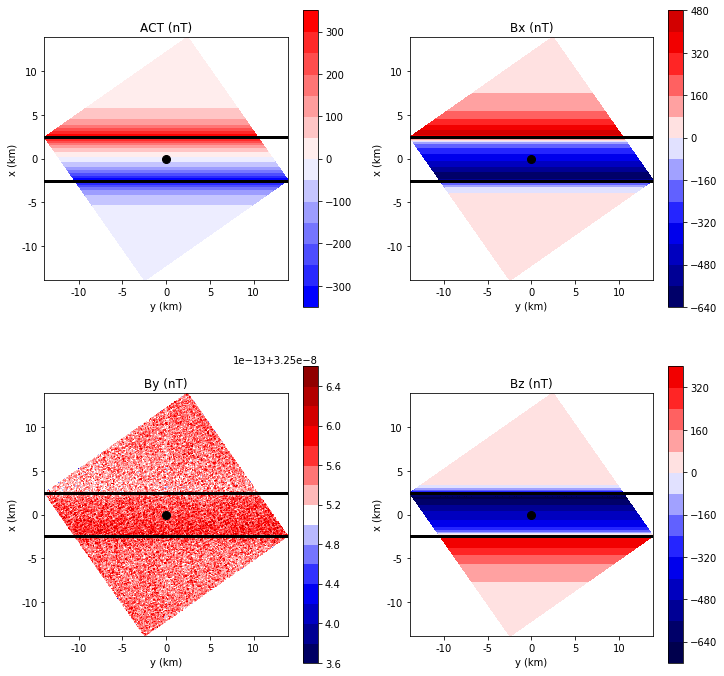

In [35]:
plt.figure(figsize=(12,12))

# Anomalia de campo total (ACT)
plt.subplot(221)
plt.title("ACT (nT)")
plt.axis('scaled')
mpl.contourf(yf, xf, act_perpendicular, shape, 15, vmin=-ranges_f, vmax=ranges_f, cmap=plt.get_cmap('seismic'))
#mpl.contourf(yf, xf, (act_perpendicular - act_f), shape, 15, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_f, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

# Componente Bx
plt.subplot(222)
plt.title("Bx (nT)")
plt.axis('scaled')
mpl.contourf(yf, xf, bx_perpendicular, shape, 15, vmin=-ranges_f, vmax=ranges_f, cmap=plt.get_cmap('seismic'))
#mpl.contourf(yf, xf, (bx_perpendicular - bx_f), shape, 15, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_f, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

# Componente By
plt.subplot(223)
plt.title("By (nT)")
plt.axis('scaled')
mpl.contourf(yf, xf, by_perpendicular, shape, 15, cmap=plt.get_cmap('seismic'))
#mpl.contourf(yf, xf, (by_perpendicular - by_f), shape, 15, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_f, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

# Componente Bz
plt.subplot(224)
plt.title("Bz (nT)")
plt.axis('scaled')
mpl.contourf(yf, xf, bz_perpendicular, shape, 15, vmin=-ranges_f, vmax=ranges_f, cmap=plt.get_cmap('seismic'))
#mpl.contourf(yf, xf, (bz_perpendicular - bz_f), shape, 15, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_f, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()


plt.show()

In [36]:
aae(act_f, act_perpendicular, decimal=5)
aae( bx_f,  bx_perpendicular, decimal=5)
aae( by_f,  by_perpendicular, decimal=5)
aae( bz_f,  bz_perpendicular, decimal=5)

### Modelo que negligencia as declinações e o azimute da fonte

In [37]:
m_tese = utils.ang2vec(int_mag, I_d, 0.)

In [38]:
model_tese = [mesher.PolygonalPrism(vertices_f, z1, z2, {'magnetization': m_tese})]

In [39]:
# Anomalia de campo total (ACT)
act_tese = polyprism.tf(xf, yf, z0, model_tese, I0_d, 0.)

# Componentes do campo de indução magnética
bx_tese = polyprism.bx(xf, yf, z0, model_tese)
by_tese = polyprism.by(xf, yf, z0, model_tese)
bz_tese = polyprism.bz(xf, yf, z0, model_tese)

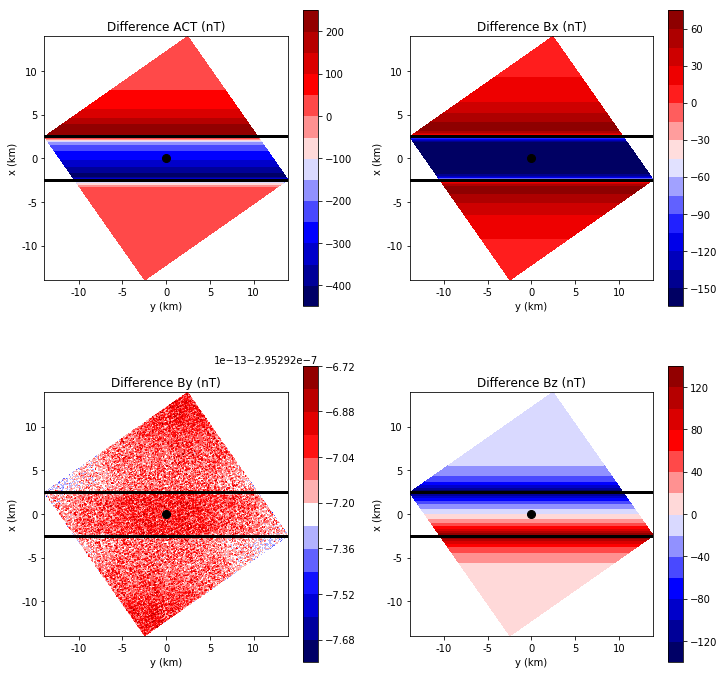

In [40]:
plt.figure(figsize=(12,12))

# Anomalia de campo total (ACT)
plt.subplot(221)
plt.title("Difference ACT (nT)")
plt.axis('scaled')
mpl.contourf(yf, xf, (act_tese - act_f), shape, 15, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_f, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

# Componente Bx
plt.subplot(222)
plt.title("Difference Bx (nT)")
plt.axis('scaled')
#mpl.contourf(yf, xf, bx_tese, shape, 15, vmin=-ranges_f, vmax=ranges_f, cmap=plt.get_cmap('seismic'))
mpl.contourf(yf, xf, (bx_tese - bx_f), shape, 15, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_f, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

# Componente By
plt.subplot(223)
plt.title("Difference By (nT)")
plt.axis('scaled')
#mpl.contourf(yf, xf, by_tese, shape, 15, cmap=plt.get_cmap('seismic'))
mpl.contourf(yf, xf, (by_tese - by_f), shape, 15, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_f, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

# Componente Bz
plt.subplot(224)
plt.title("Difference Bz (nT)")
plt.axis('scaled')
#mpl.contourf(yf, xf, bz_tese, shape, 15, vmin=-ranges_f, vmax=ranges_f, cmap=plt.get_cmap('seismic'))
mpl.contourf(yf, xf, (bz_tese - bz_f), shape, 15, cmap=plt.get_cmap('seismic'))
plt.colorbar()
mpl.polygon(projection_f, style='-k', linewidth=3, xy2ne=True)
plt.plot(0., 0., 'ko', ms=8)
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()


plt.show()

In [41]:
aae(act_f, act_tese, decimal=5)

AssertionError: 
Arrays are not almost equal to 5 decimals

(mismatch 100.0%)
 x: array([-2.2801 , -2.30188, -2.32392, ...,  4.23024,  4.19773,  4.16556])
 y: array([  7.9167 ,   7.94556,   7.97453, ...,  18.48056,  18.36415,
        18.24881])

In [42]:
aae(bx_f, bx_tese, decimal=5)

AssertionError: 
Arrays are not almost equal to 5 decimals

(mismatch 100.0%)
 x: array([ 12.17168,  12.22814,  12.28499, ...,  19.83095,  19.71131,
        19.59273])
 y: array([ 18.7503 ,  18.84302,  18.93642, ...,  26.48238,  26.32618,
        26.17135])

In [43]:
aae(by_f, by_tese, decimal=5)

In [44]:
aae(bz_f, bz_tese, decimal=5)

AssertionError: 
Arrays are not almost equal to 5 decimals

(mismatch 100.0%)
 x: array([ 21.97372,  22.10375,  22.23493, ...,  15.87597,  15.79771,
        15.72002])
 y: array([ 23.2689 ,  23.40977,  23.55192, ...,  14.55898,  14.49169,
        14.42484])

### Comparação entre as magnetizações

In [45]:
print I_d, I_f, I_parallel, I_perpendicular

-40.0 -40.0 0.0 -49.8792597915


In [46]:
print D_d, D_f, D_parallel, D_perpendicular

-10.0 -45.0 -90.0 0.0


In [47]:
tan_I_d = np.tan(np.deg2rad(I_d))
cos_D_d_minus_theta = np.cos(np.deg2rad(D_d-theta))

In [48]:
I_perpendicular_analytic = np.rad2deg(np.arctan2(tan_I_d, cos_D_d_minus_theta))

In [49]:
aae(I_perpendicular, I_perpendicular_analytic)